## Supplementary Figures 10 and 11

Plot more labels on the UMAP space

Related with Figure 2 - except we add more labels

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))

source("viz_themes.R")
source("plotting_functions.R")
source("data_functions.R")

In [2]:
output_figure_base <- file.path("figures", "supplementary", "figureS11_largeumap")
extensions <- c(".png", ".pdf")

results_dir <- file.path("../1.Data-exploration/Profiles_level4/")

In [3]:
# Load embeddings
cp_df <- load_embeddings_data(assay="cellpainting", results_dir = results_dir) %>%
    dplyr::mutate(moa_lower = tolower(moa))
l1000_df <- load_embeddings_data(assay="l1000", results_dir = results_dir) %>%
    dplyr::mutate(moa_lower = tolower(moa))

In [4]:
# Load reproducibility info
platemap_dir <- file.path("..", "1.Data-exploration", "results")

cp_platemap_file <- file.path(platemap_dir, "CellPainting_compound_metadata_plate_location_with_reproducibility.tsv.gz")
l1000_platemap_file <- file.path(platemap_dir, "L1000_compound_metadata_plate_location_with_reproducibility.tsv.gz")

cp_cols <- readr::cols(
  .default = readr::col_character(),
  no_of_compounds = readr::col_double(),
  dose_recode = readr::col_double(),
  median_score = readr::col_double(),
  p_value = readr::col_double(),
  pass_thresh = readr::col_logical(),
  neg_log_10_p_val = readr::col_double(),
  Metadata_dose_recode = readr::col_double()
)

cp_platemap_df <- readr::read_tsv(cp_platemap_file, col_types = cp_cols)

l1000_cols <- readr::cols(
  .default = readr::col_character(),
  no_of_compounds = readr::col_double(),
  dose_recode = readr::col_double(),
  median_score = readr::col_double(),
  p_value = readr::col_double(),
  pass_thresh = readr::col_logical(),
  neg_log_10_p_val = readr::col_double(),
  Metadata_dose_recode = readr::col_double()
)

l1000_platemap_df <- readr::read_tsv(l1000_platemap_file, col_types = l1000_cols)

In [5]:
# Quantify scores per MOA
l1000_moa_avg_score <- l1000_platemap_df %>%
    dplyr::group_by(moa) %>%
    dplyr::mutate(
        avg_score = median(median_score),
        cpd_count = length(median_score)
    ) %>%
    dplyr::arrange(desc(avg_score)) %>%
    dplyr::select(moa, avg_score, cpd_count) %>%
    dplyr::distinct()

cp_moa_avg_score <- cp_platemap_df %>%
    dplyr::group_by(moa) %>%
    dplyr::mutate(
        avg_score = median(median_score),
        cpd_count = length(median_score)
    ) %>%
    dplyr::arrange(desc(avg_score)) %>%
    dplyr::select(moa, avg_score, cpd_count) %>%
    dplyr::distinct()

In [6]:
# Merge scores
l1000_ready_df <- l1000_df %>%
    dplyr::left_join(l1000_moa_avg_score, by = c("moa_lower" = "moa"))

cp_ready_df <- cp_df %>%
    dplyr::left_join(cp_moa_avg_score, by = c("moa_lower" = "moa"))

In [7]:
# Identify which moas to highlight
l1000_highlight <- l1000_moa_avg_score %>%
    dplyr::mutate(
        polypharm = strsplit(as.character(moa), "\\|"),
        len_polypharm = length(unlist(polypharm))
    ) %>%
    dplyr::filter(len_polypharm == 1) %>%
    dplyr::ungroup()

# Select top 5 compounds regardless of count
top_l1000 <- l1000_highlight %>%
    dplyr::top_n(5, avg_score) %>%
    dplyr::mutate(moa_plus_score = paste(moa, round(avg_score, 2)))

# Select the next top 5, but they need to have greater than 18 cpds
mid_l1000 <- l1000_highlight %>%
    dplyr::filter(!(moa %in% top_l1000$moa)) %>%
    dplyr::filter(cpd_count > 18) %>%
    dplyr::top_n(5, avg_score) %>%
    dplyr::mutate(moa_plus_score = paste(moa, round(avg_score, 2)))

# Select bottom 5 compounds, with greater than 18 cpds
bot_l1000 <- l1000_highlight %>%
    dplyr::filter(cpd_count > 18) %>%
    dplyr::top_n(-5, avg_score) %>%
    dplyr::mutate(moa_plus_score = paste(moa, round(avg_score, 2)))

l1000_target_df <- dplyr::bind_rows(
    top_l1000, mid_l1000, bot_l1000
)

l1000_targets <- c(top_l1000 %>% dplyr::pull(moa), mid_l1000 %>% dplyr::pull(moa), bot_l1000 %>% dplyr::pull(moa))
l1000_targets

[1] "maternal embryonic leucine zipper kinase inhibitor"
 [2] "bacterial permeability inducer"                    
 [3] "exportin antagonist"                               
 [4] "proteasome inhibitor"                              
 [5] "pkc activator"                                     
 [6] "hsp inhibitor"                                     
 [7] "cdk inhibitor"                                     
 [8] "plk inhibitor"                                     
 [9] "mek inhibitor"                                     
[10] "mtor inhibitor"                                    
[11] "fatty acid synthase inhibitor"                     
[12] "thromboxane receptor antagonist"                   
[13] "bacterial antifolate"                              
[14] "dna directed dna polymerase inhibitor"             
[15] "adrenergic inhibitor"

In [8]:
# Create compounds to highlight
l1000_moa_targets_size_values <- c(rep(1, length(l1000_targets) -1), 0.1)
names(l1000_moa_targets_size_values) <- l1000_targets

l1000_moa_targets_alpha_values <- c(rep(0.5, length(l1000_targets) - 1), 0.1)
names(l1000_moa_targets_alpha_values) <- l1000_targets

l1000_ready_df <- l1000_ready_df %>% dplyr::mutate(highlight_moa = moa_lower)
l1000_ready_df$highlight_moa[!(l1000_ready_df$highlight_moa %in% l1000_targets)] <- "other"

l1000_ready_df$highlight_moa <- factor(l1000_ready_df$highlight_moa, levels = c(l1000_targets, "other"))

# Setup MOA labels with scores
l1000_label_df <- l1000_ready_df %>%
    dplyr::mutate(moa_plus_score_label = paste0(moa, " (", round(avg_score, 2), ")")) %>%
    dplyr::filter(moa_lower %in% l1000_targets) %>%
    dplyr::select(moa_lower, moa_plus_score_label) %>%
    dplyr::distinct()

l1000_moa_labels <- l1000_label_df$moa_plus_score_label
names(l1000_moa_labels) <- l1000_label_df$moa_lower

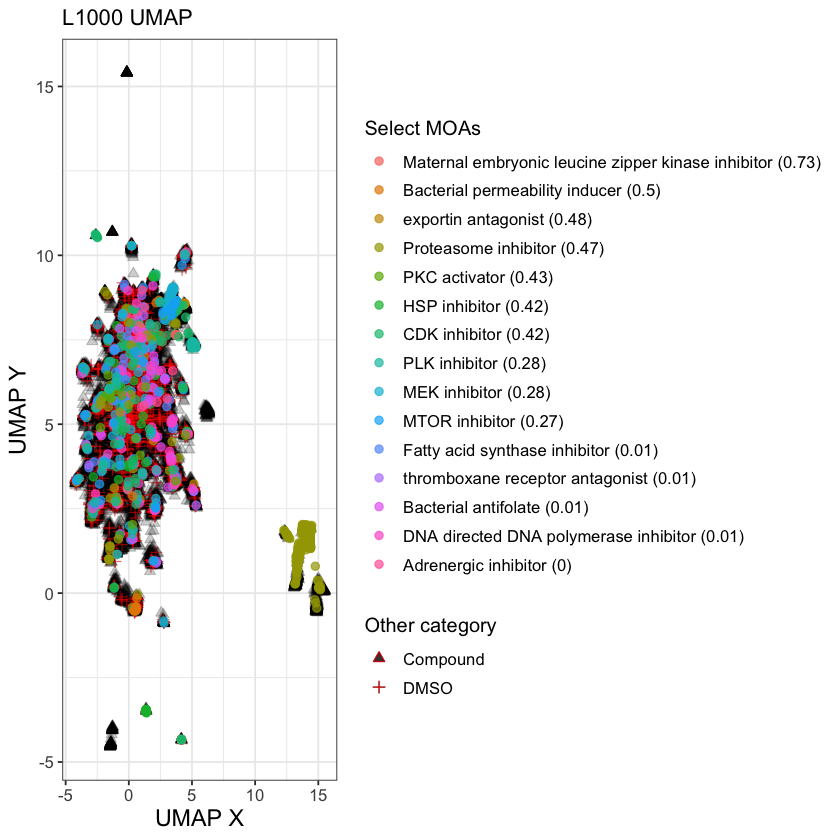

In [9]:
# Plot L1000
l1000_umap_gg <- (
    ggplot(data = NULL, aes(x = UMAP_0, y = UMAP_1))
    + geom_point(data = l1000_ready_df %>% dplyr::filter(highlight_moa == "other"), size = 2, color = "black", fill = "black", alpha = 0.2, aes(shape = dmso_label))
    + geom_point(data = l1000_ready_df %>% dplyr::filter(dmso_label == "DMSO"), size = 2, color = "red", alpha = 0.5, aes(shape = dmso_label))
    + geom_point(data = l1000_ready_df %>% dplyr::filter(highlight_moa != "other"), size = 2, alpha = 0.7, aes(color = highlight_moa))
    + ggtitle("L1000 UMAP")
    + xlab("UMAP X")
    + ylab("UMAP Y")
    + guides(alpha = FALSE, shape = guide_legend(fill = "black", override.aes = list(alpha = 0.8, size = 2)))
    + scale_shape_manual("Other category", values = c("DMSO" = 3, "compound" = 24), labels = c("DMSO" = "DMSO", "compound" = "Compound"))
    + scale_color_discrete("Select MOAs", labels = l1000_moa_labels)
    + theme_bw()
    + theme(
        axis.text = element_text(size = 10),
        axis.title = element_text(size = 14),
        legend.text = element_text(size = 10),
        legend.title = element_text(size = 12)
    )
)

for (extension in extensions) {
    output_file <- paste0(output_figure_base, "_l1000", extension)
    ggplot2::ggsave(output_file, l1000_umap_gg, height = 12, width = 15, dpi = 500)
}

l1000_umap_gg

In [10]:
# Identify which moas to highlight
cp_highlight <- cp_moa_avg_score %>%
    dplyr::mutate(
        polypharm = strsplit(as.character(moa), "\\|"),
        len_polypharm = length(unlist(polypharm))
    ) %>%
    dplyr::filter(len_polypharm == 1) %>%
    dplyr::ungroup()

# Select top 5 compounds regardless of count
top_cp <- cp_highlight %>%
    dplyr::top_n(5, avg_score) %>%
    dplyr::mutate(moa_plus_score = paste(moa, round(avg_score, 2)))

# Select the next top 5, but they need to have greater than 30 cpds
mid_cp <- cp_highlight %>%
    dplyr::filter(!(moa %in% top_cp$moa)) %>%
    dplyr::filter(cpd_count > 30) %>%
    dplyr::top_n(5, avg_score) %>%
    dplyr::mutate(moa_plus_score = paste(moa, round(avg_score, 2)))

# Select bottom 5 compounds, with greater than 30 cpds
bot_cp <- cp_highlight %>%
    dplyr::filter(cpd_count > 30) %>%
    dplyr::top_n(-5, avg_score) %>%
    dplyr::mutate(moa_plus_score = paste(moa, round(avg_score, 2)))

cp_target_df <- dplyr::bind_rows(
    top_cp, mid_cp, bot_cp
)

cp_targets <- c(top_cp %>% dplyr::pull(moa), mid_cp %>% dplyr::pull(moa), bot_cp %>% dplyr::pull(moa))
cp_targets

[1] "exportin antagonist"                               
 [2] "maternal embryonic leucine zipper kinase inhibitor"
 [3] "fgfr antagonist"                                   
 [4] "tubulin polymerization inhibitor"                  
 [5] "plk inhibitor"                                     
 [6] "proteasome inhibitor"                              
 [7] "aurora kinase inhibitor"                           
 [8] "cdk inhibitor"                                     
 [9] "microtubule inhibitor"                             
[10] "glucocorticoid receptor agonist"                   
[11] "fatty acid synthase inhibitor"                     
[12] "cytochrome p450 inhibitor"                         
[13] "tricyclic antidepressant"                          
[14] "aldose reductase inhibitor"                        
[15] "glutamate receptor modulator"

In [11]:
# Create compounds to highlight
cp_moa_targets_size_values <- c(rep(1, length(cp_targets) -1), 0.1)
names(cp_moa_targets_size_values) <- cp_targets

moa_targets_alpha_values <- c(rep(0.5, length(cp_targets) - 1), 0.1)
names(moa_targets_alpha_values) <- cp_targets

cp_ready_df <- cp_ready_df %>% dplyr::mutate(highlight_moa = moa_lower)
cp_ready_df$highlight_moa[!(cp_ready_df$highlight_moa %in% cp_targets)] <- "other"

cp_ready_df$highlight_moa <- factor(cp_ready_df$highlight_moa, levels = c(cp_targets, "other"))

# Setup MOA labels with scores
label_df <- cp_ready_df %>%
    dplyr::mutate(moa_plus_score_label = paste0(moa, " (", round(avg_score, 2), ")")) %>%
    dplyr::filter(moa_lower %in% cp_targets) %>%
    dplyr::select(moa_lower, moa_plus_score_label) %>%
    dplyr::distinct()

moa_labels <- label_df$moa_plus_score_label
names(moa_labels) <- label_df$moa_lower

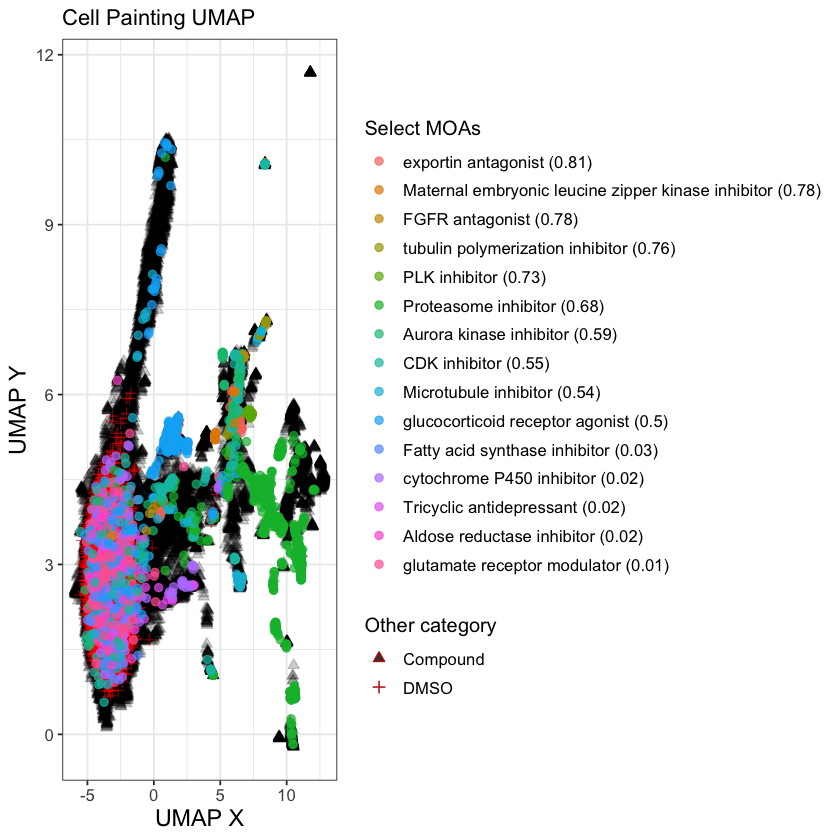

In [12]:
# Plot Cell Painting
cp_umap_gg <- (
    ggplot(data = NULL, aes(x = UMAP_0, y = UMAP_1))
    + geom_point(data = cp_ready_df %>% dplyr::filter(highlight_moa == "other"), size = 2, color = "black", fill = "black", alpha = 0.2, aes(shape = dmso_label))
    + geom_point(data = cp_ready_df %>% dplyr::filter(dmso_label == "DMSO"), size = 2, color = "red", alpha = 0.5, aes(shape = dmso_label))
    + geom_point(data = cp_ready_df %>% dplyr::filter(highlight_moa != "other"), size = 2, alpha = 0.7, aes(color = highlight_moa))
    + ggtitle("Cell Painting UMAP")
    + xlab("UMAP X")
    + ylab("UMAP Y")
    + guides(alpha = FALSE, shape = guide_legend(fill = "black", override.aes = list(alpha = 0.8, size = 2)))
    + scale_shape_manual("Other category", values = c("DMSO" = 3, "compound" = 24), labels = c("DMSO" = "DMSO", "compound" = "Compound"))
    + scale_color_discrete("Select MOAs", labels = moa_labels)
    + theme_bw()
    + theme(
        axis.text = element_text(size = 10),
        axis.title = element_text(size = 14),
        legend.text = element_text(size = 10),
        legend.title = element_text(size = 12)
    )
)

output_figure_base <- file.path("figures", "supplementary", "figureS10_largeumap")

for (extension in extensions) {
    output_file <- paste0(output_figure_base, "_cellpainting", extension)
    ggplot2::ggsave(output_file, cp_umap_gg, height = 12, width = 15, dpi = 500)
}

cp_umap_gg